<a href="https://colab.research.google.com/github/Qasim-Shah-73/Brain-Tumor-Detection-using-MRI-Dataset./blob/master/Brain_Tumor_Detection_using_MRI_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MRI Images Dataset**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Brain Tumor Classification using RESNET 50**

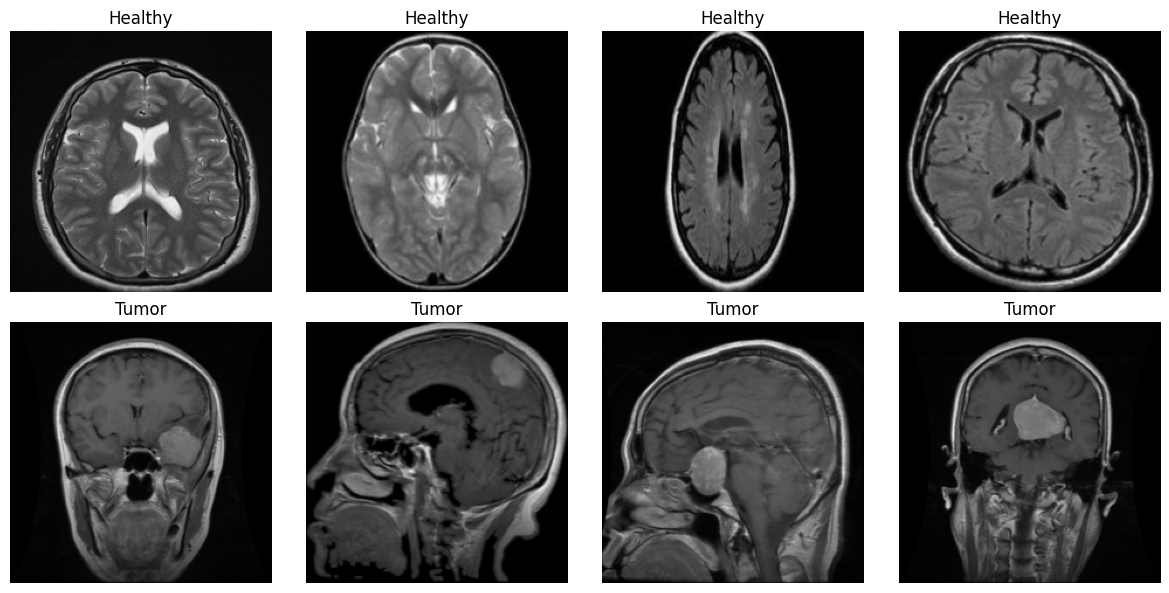

Epoch 1/10: Train Loss: 0.2068 Train Acc: 0.9146 Val Acc: 0.9800
Epoch 2/10: Train Loss: 0.0322 Train Acc: 0.9931 Val Acc: 0.9890
Epoch 3/10: Train Loss: 0.0081 Train Acc: 0.9991 Val Acc: 0.9930
Epoch 4/10: Train Loss: 0.0065 Train Acc: 0.9989 Val Acc: 0.9950
Epoch 5/10: Train Loss: 0.0029 Train Acc: 1.0000 Val Acc: 0.9990
Epoch 6/10: Train Loss: 0.0024 Train Acc: 1.0000 Val Acc: 0.9980
Epoch 7/10: Train Loss: 0.0026 Train Acc: 0.9997 Val Acc: 0.9960
Epoch 8/10: Train Loss: 0.0021 Train Acc: 1.0000 Val Acc: 0.9970
Epoch 9/10: Train Loss: 0.0017 Train Acc: 1.0000 Val Acc: 0.9950
Epoch 10/10: Train Loss: 0.0011 Train Acc: 1.0000 Val Acc: 0.9960
Training complete.


In [ ]:

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Set paths to the dataset folders
MRI_PATH = "/content/drive/My Drive/Dataset/Brain Tumor MRI images"
HEALTHY_PATH = os.path.join(MRI_PATH, "Healthy")
TUMOR_PATH   = os.path.join(MRI_PATH, "Tumor")

# Define a custom dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, healthy_dir, tumor_dir, transform=None):
        self.transform = transform
        self.data = []   # list of (image_path, label)

        # Label 0 for healthy, 1 for tumor
        for fname in os.listdir(healthy_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.data.append((os.path.join(healthy_dir, fname), 0))
        for fname in os.listdir(tumor_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.data.append((os.path.join(tumor_dir, fname), 1))
        random.shuffle(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transforms (resize, normalization, augmentation for training)
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet means
                         [0.229, 0.224, 0.225])  # ImageNet stds
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Create dataset
full_dataset = BrainTumorDataset(HEALTHY_PATH, TUMOR_PATH, transform=train_transform)

# Display a few sample images from each class
def show_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples*3, 6))
    count = {0: 0, 1: 0}  # counters for each class
    for img, label in dataset:
        if count[label] < num_samples:
            row = label  # row 0: healthy, row 1: tumor
            ax = axes[row, count[label]]
            # Undo normalization for display:
            img_disp = img.clone()
            img_disp = img_disp * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            img_disp = img_disp.clamp(0, 1)
            ax.imshow(np.transpose(img_disp.numpy(), (1,2,0)))
            ax.set_title("Healthy" if label==0 else "Tumor")
            ax.axis('off')
            count[label] += 1
        if count[0] >= num_samples and count[1] >= num_samples:
            break
    plt.tight_layout()
    plt.show()

# Use the original dataset with a basic transform for display (without augmentation)
display_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
display_dataset = BrainTumorDataset(HEALTHY_PATH, TUMOR_PATH, transform=display_transform)
show_samples(display_dataset)

# Split dataset into train, validation, and test sets (70%, 20%, 10%)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size],
                                                        generator=torch.Generator().manual_seed(42))

# For evaluation, we'll create a separate DataLoader for the test set using the validation transform (no augmentation)
test_dataset.dataset.transform = val_transform  # update transform in test split

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)  # batch=1 for detailed evaluation

# Define the model: Fine-tune a pre-trained ResNet50 for binary classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
# Modify the final fully-connected layer to output 2 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc  = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()

    print("Training complete.")
    model.load_state_dict(best_model_wts)
    return model

# Train the model
num_epochs = 10
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)




Test sample predictions:


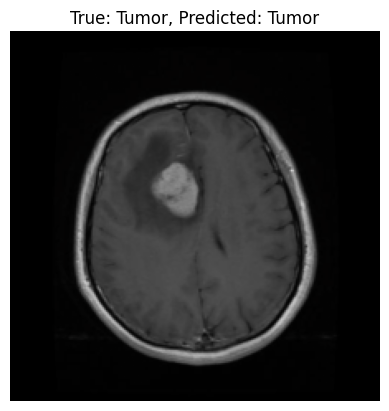

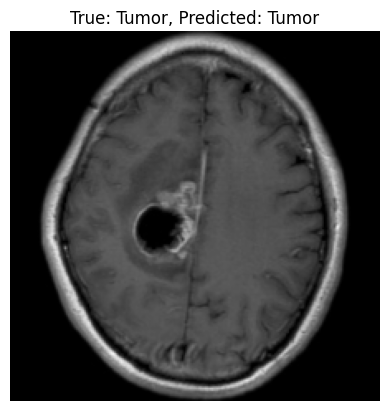

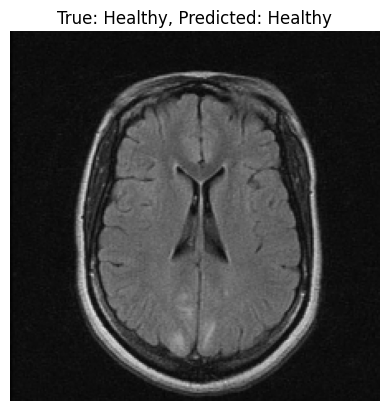

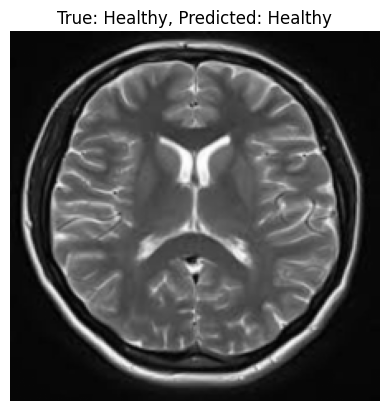

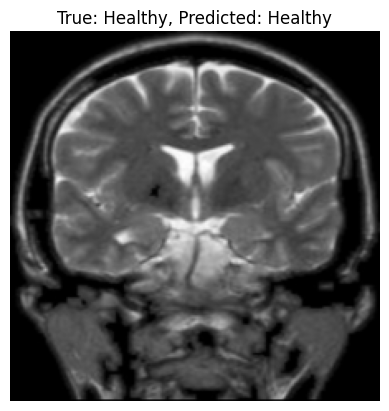

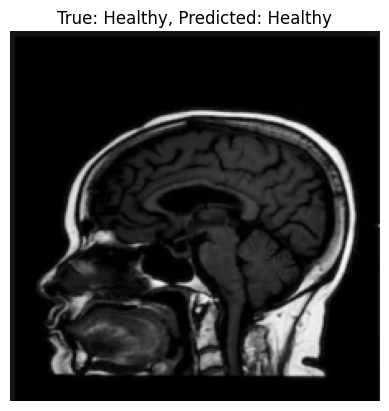

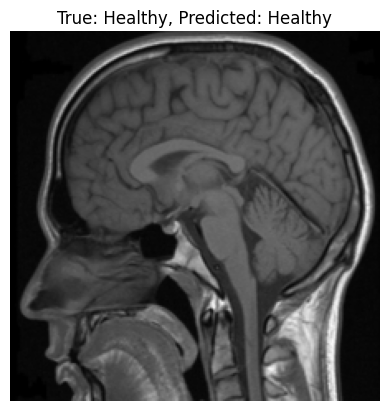

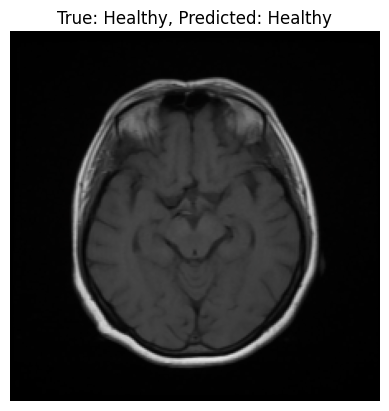

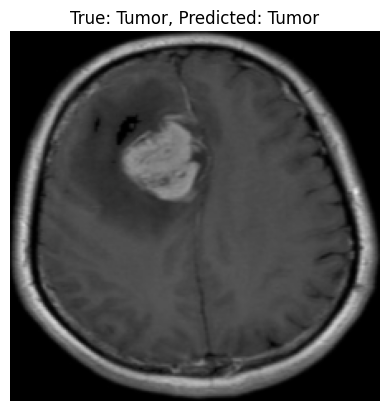

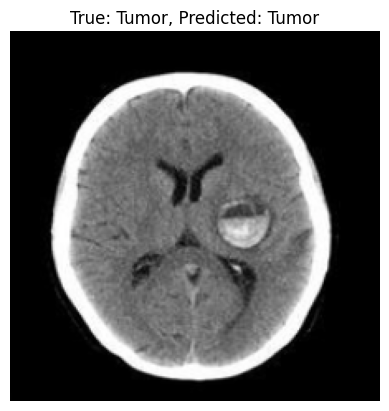

Test Accuracy: 0.9940


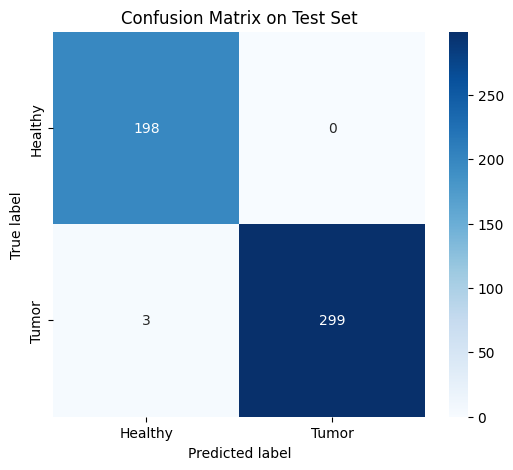

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.99      1.00      0.99       198
       Tumor       1.00      0.99      1.00       302

    accuracy                           0.99       500
   macro avg       0.99      1.00      0.99       500
weighted avg       0.99      0.99      0.99       500



In [ ]:
# Evaluate on test set using 10 random images
model.eval()
test_images = []
test_labels = []
pred_labels = []
all_outputs = []

# Collect predictions for 10 test images
count = 0
for inputs, labels in test_loader:
    if count >= 10:
        break
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    test_images.append(inputs.cpu())  # Store the input image
    test_labels.append(labels.cpu().item())  # Store true label
    pred_labels.append(preds.cpu().item())  # Store predicted label

    all_outputs.append(outputs.cpu().detach().numpy())
    count += 1


# Display the 10 test images with predictions
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.squeeze(0)  # remove batch dim
    inp = inp * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    inp = inp.clamp(0, 1)
    npimg = inp.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis("off")

print("Test sample predictions:")
for i in range(len(test_images)):
    label = "Healthy" if test_labels[i] == 0 else "Tumor"
    pred  = "Healthy" if pred_labels[i] == 0 else "Tumor"
    plt.figure()
    imshow(test_images[i], title=f"True: {label}, Predicted: {pred}")
    plt.show()

# Detailed evaluation on the entire test set
all_true = []
all_pred = []
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    all_true.append(labels.cpu().item())
    all_pred.append(preds.cpu().item())

# Compute evaluation metrics
acc = accuracy_score(all_true, all_pred)
print(f"Test Accuracy: {acc:.4f}")

cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Healthy", "Tumor"],
            yticklabels=["Healthy", "Tumor"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix on Test Set")
plt.show()

print("Classification Report:")
print(classification_report(all_true, all_pred, target_names=["Healthy", "Tumor"]))

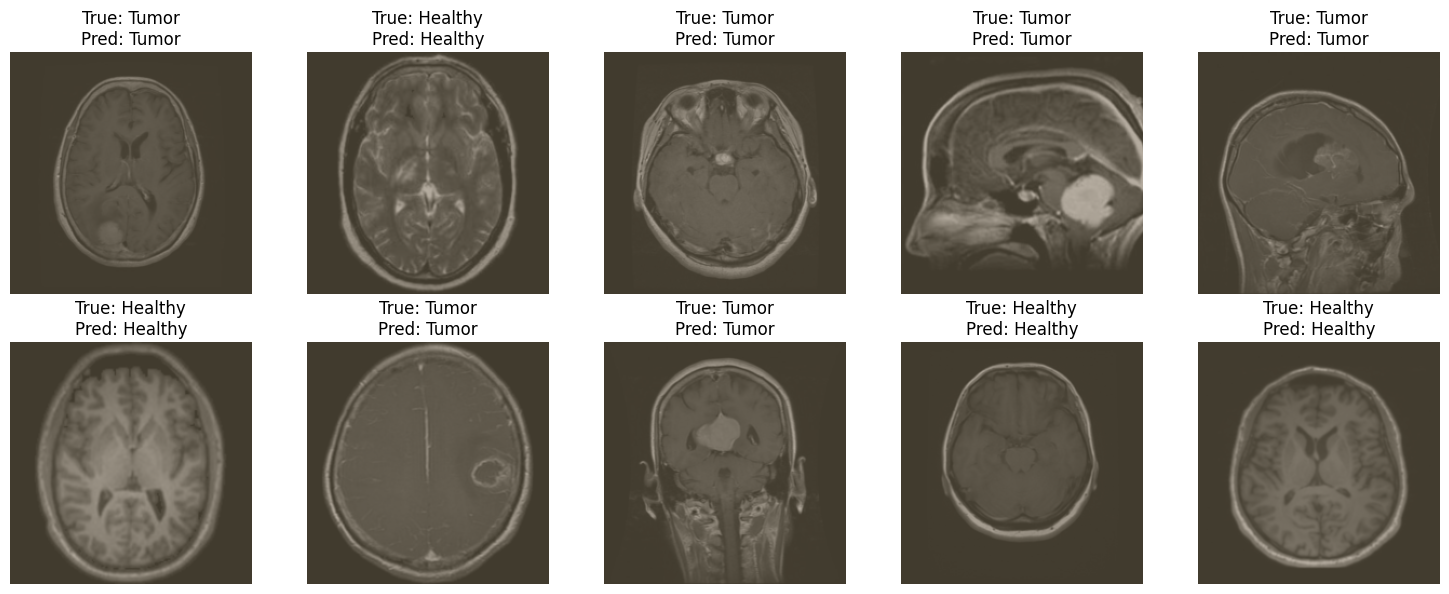

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display an image
def imshow(img, title):
    """Display an image after reversing normalization."""
    img = img.squeeze(0)  # Remove batch dimension
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)  # Undo normalization
    img = img.clamp(0, 1)  # Clip values to valid range
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert tensor to image
    plt.title(title, fontsize=12)
    plt.axis("off")

# Evaluate on 10 random test images using ResNet-50
model.eval()
test_images = []
test_labels = []
pred_labels = []

count = 0
for inputs, labels in test_loader:
    if count >= 10:
        break
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Perform inference
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Store images, labels, and predictions
    test_images.append(inputs.cpu())
    test_labels.append(labels.cpu().item())
    pred_labels.append(preds.cpu().item())

    count += 1

# Display the 10 test images with their predicted labels
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
    label = "Healthy" if test_labels[i] == 0 else "Tumor"
    pred  = "Healthy" if pred_labels[i] == 0 else "Tumor"
    imshow(test_images[i], title=f"True: {label}\nPred: {pred}")
plt.tight_layout()
plt.show()


**Brain Tumor Classification using Vision Transformer (ViT) Model**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/10: Train Loss: 0.2558 Train Acc: 0.8911 Val Acc: 0.9570
Epoch 2/10: Train Loss: 0.0376 Train Acc: 0.9869 Val Acc: 0.9660
Epoch 3/10: Train Loss: 0.0120 Train Acc: 0.9946 Val Acc: 0.9940
Epoch 4/10: Train Loss: 0.0317 Train Acc: 0.9877 Val Acc: 0.9960
Epoch 5/10: Train Loss: 0.0249 Train Acc: 0.9914 Val Acc: 0.9940
Epoch 6/10: Train Loss: 0.0189 Train Acc: 0.9923 Val Acc: 0.9920
Epoch 7/10: Train Loss: 0.0086 Train Acc: 0.9966 Val Acc: 0.9900
Epoch 8/10: Train Loss: 0.0142 Train Acc: 0.9951 Val Acc: 0.9810
Epoch 9/10: Train Loss: 0.0107 Train Acc: 0.9951 Val Acc: 0.9810
Epoch 10/10: Train Loss: 0.0100 Train Acc: 0.9969 Val Acc: 0.9620
Training complete.
Test Accuracy: 0.9720


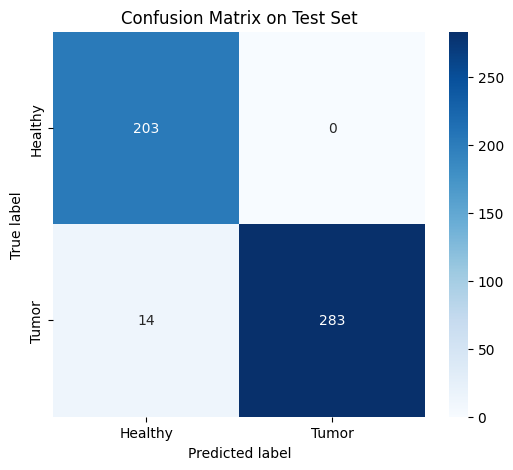

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.94      1.00      0.97       203
       Tumor       1.00      0.95      0.98       297

    accuracy                           0.97       500
   macro avg       0.97      0.98      0.97       500
weighted avg       0.97      0.97      0.97       500



In [ ]:
# Import required libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Install and import timm (for ViT)
import timm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set paths to the dataset folders
MRI_PATH = "/content/drive/My Drive/Dataset/Brain Tumor MRI images"
HEALTHY_PATH = os.path.join(MRI_PATH, "Healthy")
TUMOR_PATH   = os.path.join(MRI_PATH, "Tumor")

# Define a custom dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, healthy_dir, tumor_dir, transform=None):
        self.transform = transform
        self.data = []   # list of (image_path, label)

        # Label 0 for healthy, 1 for tumor
        for fname in os.listdir(healthy_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.data.append((os.path.join(healthy_dir, fname), 0))
        for fname in os.listdir(tumor_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.data.append((os.path.join(tumor_dir, fname), 1))
        random.shuffle(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transforms (resize, normalization, augmentation for training)
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],  # Normalization for ViT
                         [0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

# Create dataset
full_dataset = BrainTumorDataset(HEALTHY_PATH, TUMOR_PATH, transform=train_transform)

# Split dataset into train, validation, and test sets (70%, 20%, 10%)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size],
                                                        generator=torch.Generator().manual_seed(42))

# For evaluation, we'll use the validation transform (no augmentation)
test_dataset.dataset.transform = val_transform

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)  # batch=1 for detailed evaluation

# Define the Vision Transformer model (ViT_base_16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify the final classification head to output 2 classes (Healthy vs Tumor)
num_features = model.head.in_features
model.head = nn.Linear(num_features, 2)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc  = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()

    print("Training complete.")
    model.load_state_dict(best_model_wts)
    return model

# Train the ViT model
num_epochs = 10
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

# Evaluate on test set
all_true = []
all_pred = []
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    all_true.append(labels.cpu().item())
    all_pred.append(preds.cpu().item())

# Compute evaluation metrics
acc = accuracy_score(all_true, all_pred)
print(f"Test Accuracy: {acc:.4f}")

cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Healthy", "Tumor"],
            yticklabels=["Healthy", "Tumor"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix on Test Set")
plt.show()

print("Classification Report:")
print(classification_report(all_true, all_pred, target_names=["Healthy", "Tumor"]))


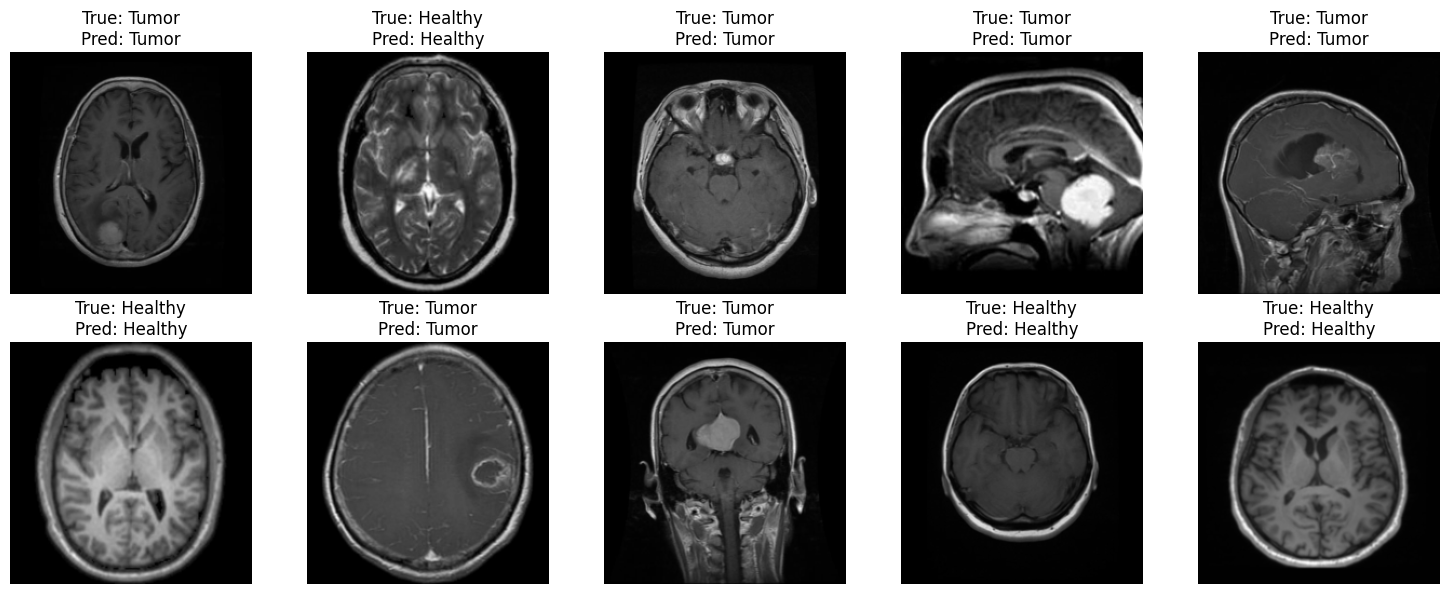

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display an image
def imshow(img, title):
    """Display an image after reversing normalization."""
    img = img.squeeze(0)  # Remove batch dimension
    img = img * torch.tensor([0.5, 0.5, 0.5]).view(3,1,1) + torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)  # Undo normalization
    img = img.clamp(0, 1)  # Clip values to valid range
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert tensor to image
    plt.title(title, fontsize=12)
    plt.axis("off")

# Evaluate on 10 random test images using Vision Transformer (ViT)
model.eval()
test_images = []
test_labels = []
pred_labels = []

count = 0
for inputs, labels in test_loader:
    if count >= 10:
        break
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Perform inference
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Store images, labels, and predictions
    test_images.append(inputs.cpu())
    test_labels.append(labels.cpu().item())
    pred_labels.append(preds.cpu().item())

    count += 1

# Display the 10 test images with their predicted labels
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
    label = "Healthy" if test_labels[i] == 0 else "Tumor"
    pred  = "Healthy" if pred_labels[i] == 0 else "Tumor"
    imshow(test_images[i], title=f"True: {label}\nPred: {pred}")
plt.tight_layout()
plt.show()


**Hybrid CNN-ViT Model for Brain Tumor MRI Classification**

In [ ]:
# Import required libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Install and import timm (for ViT)
import timm

# ✅ Restart kernel if needed
import os
#os._exit(00)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set dataset paths
MRI_PATH = "/content/drive/My Drive/Dataset/Brain Tumor MRI images"
HEALTHY_PATH = os.path.join(MRI_PATH, "Healthy")
TUMOR_PATH   = os.path.join(MRI_PATH, "Tumor")

# Define dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, healthy_dir, tumor_dir, transform=None):
        self.transform = transform
        self.data = []   # List of (image_path, label)

        for fname in os.listdir(healthy_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.data.append((os.path.join(healthy_dir, fname), 0))  # Healthy = 0

        for fname in os.listdir(tumor_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.data.append((os.path.join(tumor_dir, fname), 1))  # Tumor = 1

        random.shuffle(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Create dataset
full_dataset = BrainTumorDataset(HEALTHY_PATH, TUMOR_PATH, transform=train_transform)

# Split dataset (70% train, 20% val, 10% test)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size],
                                                        generator=torch.Generator().manual_seed(42))

# Apply validation transforms to test dataset
test_dataset.dataset.transform = val_transform

# ✅ Reduce batch size to avoid CUDA memory issues
batch_size = 8

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

# ✅ Define Hybrid CNN-ViT Model (Fixed)
class HybridCNNViT(nn.Module):
    def __init__(self):
        super(HybridCNNViT, self).__init__()

        # Load pre-trained ResNet-50 (CNN feature extractor)
        self.cnn = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-2])  # Remove FC layers

        # Reduce channels: Convert 2048 → 3 using 1x1 Conv
        self.channel_reducer = nn.Conv2d(2048, 3, kernel_size=1)

        # Adaptive pooling to match ViT input (224x224)
        self.pool = nn.AdaptiveAvgPool2d((224, 224))

        # Load pre-trained ViT model
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vit.head = nn.Linear(768, 2)  # Modify classification head for 2 classes (Healthy/Tumor)

    def forward(self, x):
        x = x.to(device)  # Ensure input is on correct device
        x = self.cnn(x)  # Extract CNN features (batch_size, 2048, H, W)
        x = self.channel_reducer(x)  # Convert 2048 → 3 channels
        x = self.pool(x)  # Resize to (batch_size, 3, 224, 224)
        x = self.vit(x)   # Pass through ViT
        return x

# ✅ Initialize model properly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HybridCNNViT()
model = model.to(device)  # Ensure model is on GPU

# ✅ Debug CUDA Memory Issues
print(torch.cuda.memory_summary(device=None, abbreviated=False))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc  = running_corrects.double() / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f}")

    print("Training complete.")
    return model

# ✅ Train the Hybrid CNN-ViT model
num_epochs = 10
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 430067 KiB | 430067 KiB | 430067 KiB |      0 B   |
|       from large pool | 411136 KiB | 411136 KiB | 411136 KiB |      0 B   |
|       from small pool |  18931 KiB |  18931 KiB |  18931 KiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         | 430067 KiB | 430067 KiB | 430067 KiB |      0 B   |
|       from large pool | 411136 KiB | 411136 KiB | 411136 KiB |


✅ Test Accuracy: 0.9980


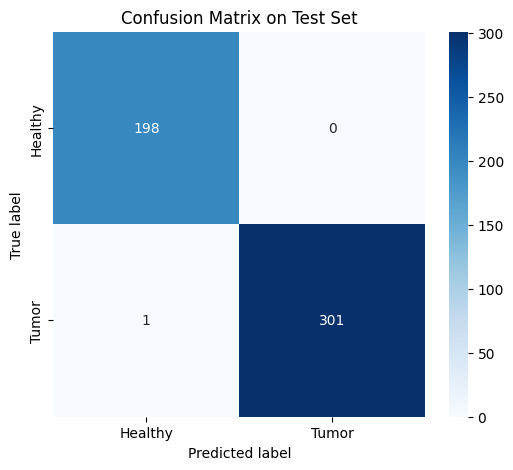


📌 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.99      1.00      1.00       198
       Tumor       1.00      1.00      1.00       302

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Evaluate the model on the entire test dataset
def evaluate_model(model, test_loader):
    model.eval()
    all_true = []
    all_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_true.append(labels.cpu().item())
            all_pred.append(preds.cpu().item())

    # Compute accuracy
    acc = accuracy_score(all_true, all_pred)
    print(f"\n✅ Test Accuracy: {acc:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(all_true, all_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Healthy", "Tumor"],
                yticklabels=["Healthy", "Tumor"])
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title("Confusion Matrix on Test Set")
    plt.show()

    # Print classification report
    print("\n📌 Classification Report:")
    print(classification_report(all_true, all_pred, target_names=["Healthy", "Tumor"]))

# Run the evaluation
evaluate_model(model, test_loader)


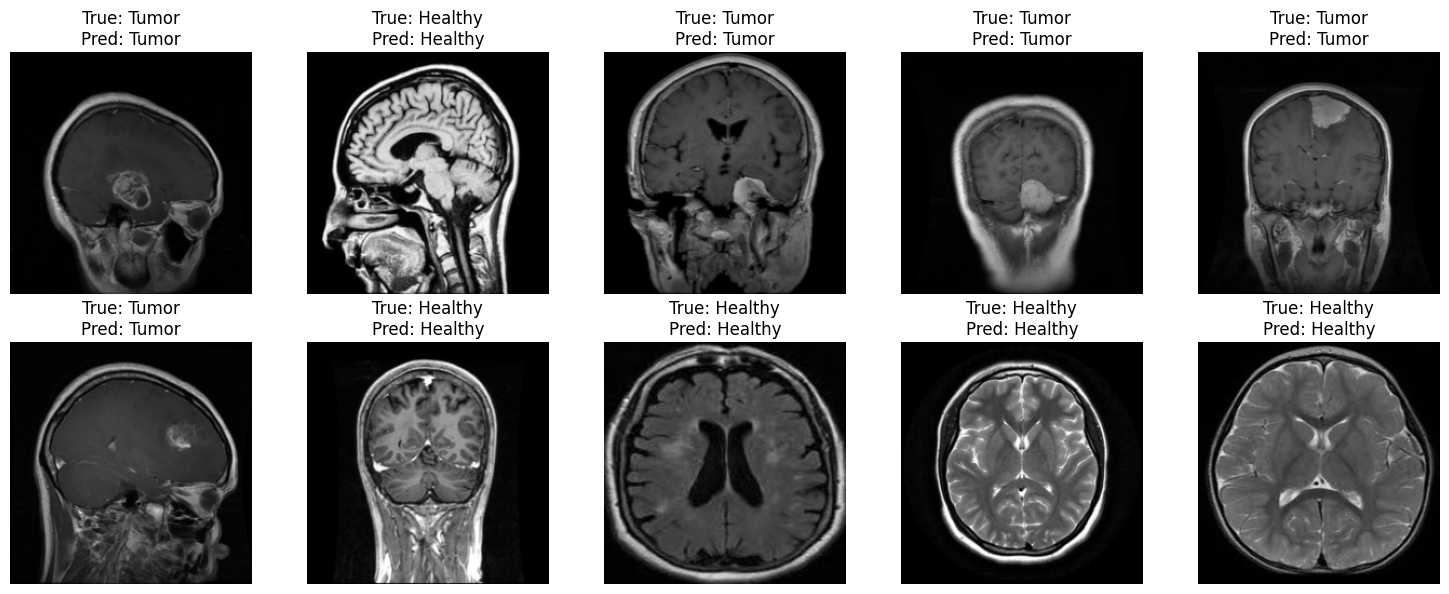

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to display an image with true and predicted labels
def imshow(img, title):
    """Display an image after reversing normalization."""
    img = img.squeeze(0)  # Remove batch dimension
    img = img * torch.tensor([0.5, 0.5, 0.5]).view(3,1,1) + torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)  # Undo normalization
    img = img.clamp(0, 1)  # Clip values to valid range
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert tensor to image
    plt.title(title, fontsize=12)
    plt.axis("off")

# Function to test 10 sample images
def test_10_sample_images(model, test_loader):
    model.eval()
    test_images = []
    test_labels = []
    pred_labels = []

    count = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            if count >= 10:
                break
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            test_images.append(inputs.cpu())  # Store image
            test_labels.append(labels.cpu().item())  # Store true label
            pred_labels.append(preds.cpu().item())  # Store predicted label

            count += 1

    # Display the 10 test images with predictions
    plt.figure(figsize=(15, 6))
    for i in range(10):
        plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
        label = "Healthy" if test_labels[i] == 0 else "Tumor"
        pred  = "Healthy" if pred_labels[i] == 0 else "Tumor"
        imshow(test_images[i], title=f"True: {label}\nPred: {pred}")
    plt.tight_layout()
    plt.show()

# Run the testing on 10 sample images
test_10_sample_images(model, test_loader)
